In [1]:
import os
from pathlib import PurePath, Path
import ssl

import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2022-11-14 23:09:39.412499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### SSL Certificate for downloading


In [2]:
ssl._create_default_https_context = ssl._create_unverified_context

### Downloading and extracting images dataset


In [5]:
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
data_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=dataset_url, extract=True)
print(data_dir)

/Users/petrklepetko/.keras/datasets/cats_and_dogs_filtered.zip


### Dataset path


In [8]:
data_dir = os.path.join(os.path.dirname(data_dir), 'cats_and_dogs_filtered_merged')
data_dir = Path(data_dir)
print(data_dir)

/Users/petrklepetko/.keras/datasets/cats_and_dogs_filtered_merged


### Creating training and validation datasets


In [10]:
img_height,img_width=180,180
batch_size=32
seed=1337
validation_split=0.2

print('=====Testing=====')

train = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  subset="training",
  validation_split=validation_split,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)


print('\r\n=====Validation=====')

val = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  subset="validation",
  validation_split=validation_split,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

=====Testing=====
Found 3000 files belonging to 2 classes.
Using 2400 files for training.

=====Validation=====
Found 3000 files belonging to 2 classes.
Using 600 files for validation.


2022-11-14 23:18:23.688114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Dataset labels

In [12]:
class_names = train.class_names
print(class_names)

['cats', 'dogs']


### Data view


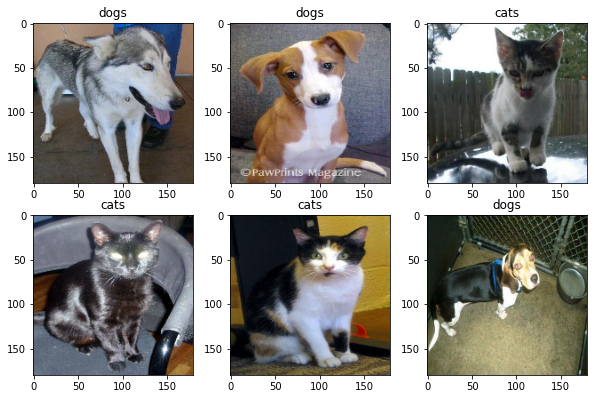

In [13]:
plt.figure(figsize=(10, 10))

# take 1 batch
for images, labels in train.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

### Adjusting Resnet50


In [14]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(180,180,3),
    pooling='avg',
    weights='imagenet',
    classes=2)


for layer in pretrained_model.layers:
    layer.trainable=False

resnet_model.add(pretrained_model)

94765736/94765736 [==============================] - 9s 0us/step


In [15]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, activation='sigmoid'))

In [16]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 1,050,114
Non-trainable params: 23,587,712
_________________________________________________________________


### Training


In [17]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model = resnet_model.fit(train, validation_data=val, epochs=5)

Epoch 1/5
75/75 [==============================] - 126s 2s/step - loss: 0.2548 - accuracy: 0.9321 - val_loss: 0.0917 - val_accuracy: 0.9683
Epoch 2/5
75/75 [==============================] - 142s 2s/step - loss: 0.0516 - accuracy: 0.9779 - val_loss: 0.0939 - val_accuracy: 0.9683
Epoch 3/5
75/75 [==============================] - 148s 2s/step - loss: 0.0254 - accuracy: 0.9904 - val_loss: 0.1053 - val_accuracy: 0.9683
Epoch 4/5
75/75 [==============================] - 156s 2s/step - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.1143 - val_accuracy: 0.9717
Epoch 5/5
75/75 [==============================] - 155s 2s/step - loss: 0.0074 - accuracy: 0.9992 - val_loss: 0.1174 - val_accuracy: 0.9700


### Accuracy and Loss fn on training and validation datasets


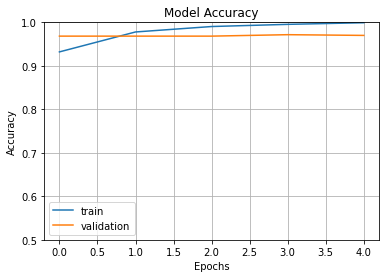

In [20]:
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.axis(ymin=0.5,ymax=1)
plt.grid()

plt.show()

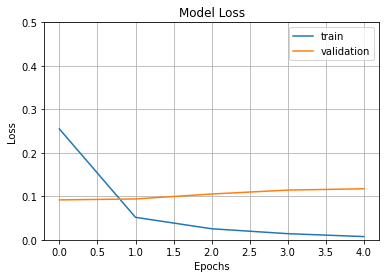

In [21]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.axis(ymin=0,ymax=0.5)
plt.grid()

plt.show()

### Testing model on custom pictures


In [22]:
test_data_dir=Path(Path().parent.absolute(), 'example_pictures')
example_pictures = sorted(list(test_data_dir.glob('*.jpg')))

1/1 [==============================] - 0s 83ms/step


(-0.5, 1205.5, 1205.5, -0.5)

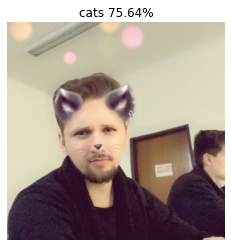

In [28]:
index = 2

#load image
image=cv2.imread(str(example_pictures[index]))
#resize image
image_resized= cv2.resize(image, (img_height,img_width))
#expand dimensions
expanded_image=np.expand_dims(image_resized,axis=0)

pred=np.squeeze(resnet_model.predict(expanded_image))
confidence = pred[np.argmax(pred)] * 100
output_class=class_names[np.argmax(pred)]

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'{output_class} {str(round(confidence, 2))}%');
plt.axis("off")